# Artificial Neural Networks in Hamiltonian Dynamics

Using the ResNet architecture to solve a separable Hamiltonian problem i mechanics. 

[1.68161268 0.02734376]
Z:
[ 4.99674049 -0.20236078]
[ 4.99674049 -0.20236078]
[1.68161268 0.02734376]
J:
5.5214183026794
Z:
[ 2.27704295 -0.08113095]
[ 2.27704295 -0.08113095]
[1.68161268 0.02734376]
J:
0.18315198874602592
Z:
[ 2.04740295 -0.08976561]
[ 2.04740295 -0.08976561]
[1.68161268 0.02734376]
J:
0.07375856524415328
Z:
[ 1.96522472 -0.09010187]
[ 1.96522472 -0.09010187]
[1.68161268 0.02734376]
J:
0.047114633552549544
Z:
[ 1.91873689 -0.08926614]
[ 1.91873689 -0.08926614]
[1.68161268 0.02734376]
J:
0.03491288144158339
Z:
[ 1.88644048 -0.08821751]
[ 1.88644048 -0.08821751]
[1.68161268 0.02734376]
J:
0.027654418217333464
Z:
[ 1.86151468 -0.08713443]
[ 1.86151468 -0.08713443]
[1.68161268 0.02734376]
J:
0.022734992828686348
Z:
[ 1.84113259 -0.08605109]
[ 1.84113259 -0.08605109]
[1.68161268 0.02734376]
J:
0.019152498143281845
Z:
[ 1.82389487 -0.0849702 ]
[ 1.82389487 -0.0849702 ]
[1.68161268 0.02734376]
J:
0.016429324656855763
Z:
[ 1.80901002 -0.08388804]
[ 1.80901002 -0.08388804]
[1

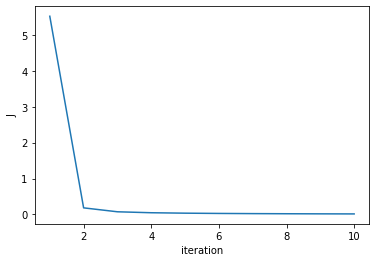

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 4 is different from 2)

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import math
import numpy.linalg as la

# Strange way to arrange the code here.
# Needs to be improved, but that can be done along the way.

#for adams
def root(v_j):
    for i in range(4):
        v_j[i] = np.sqrt(v_j[i])
    return v_j


class Parameters:
    def __init__(self,K,d,I,iterations):
        self.W_k = np.random.randn(K,d,d)
        self.b_k = np.random.randn(K,d,1)
        self.b_k_I = np.zeros((K,d,I))
        for i in range(K):
            self.b_k_I[i,:,:] = self.b_k[i,:,:]

        self.omega = np.random.randn(d)  
        self.my = np.random.rand()
        self.K = K
        
        #for Adam descent
        self.beta_1 = 0.9; self.beta_2 = 0.999; self.alpha = 0.01; self.epsilon = 10E-8
        self.v = [0]; self.m = [0]
        
        
    def update(self,gradient,method,tau,j):
        # Den måten her å skille mellom vanilla of adams bør kunne utbedres, 
        # nå som alt skrives i den samme klassen. Dette var veldig jalla. 
        if(method == "vanilla"):
            self.W_k = self.W_k - tau*gradient[0]
            self.b_k = self.b_k - tau*gradient[1]
            for i in range(self.K):
                self.b_k_I[i,:,:] = self.b_k[i,:,:]
            self.omega = self.omega - tau*gradient[2]
            self.my = self.my - tau*gradient[3]
            
        elif(method == "adams"):
            g = gradient 
            self.m.append( self.beta_1*self.m[j-1] + (1-self.beta_1)*g)
            self.v.append(self.beta_2*self.v[j-1]+(1-self.beta_2)*(g*g))
            m_hat = self.m[j]/(1-self.beta_1**j)
            v_hat = self.v[j]/(1-self.beta_2**j)
            subtract = self.alpha*m_hat/(root(self.v[j])+self.epsilon)
            
            self.W_k = self.W_k - subtract[0]
            self.b_k = self.b_k - subtract[1]
            for i in range(self.K):
                self.b_k_I[i,:,:] = self.b_k[i,:,:]
            self.omega = self.omega - subtract[2]
            self.my = self.my - subtract[3]      
                      
        else:
            print("No method found") 
    


class Network:
    def __init__(self,K,d,I,h,Y_0,c,iterations):
        self.U = Parameters(K,d,I,iterations)
        self.Y_list = np.zeros((K+1,d,I))
        self.Y_list[0,:,:] = Y_0
        self.h = h
        self.K = K
        self.I = I
        self.d = d
        self.Z = None

    
    def forward_function(self): # returns Z
        for i in range(self.K):
            #jmf. formel (1) i heftet
            self.Y_list[i+1,:,:] = self.Y_list[i,:,:] + self.h*self.sigma(self.U.W_k[i,:,:] @ self.Y_list[i,:,:] + self.U.b_k_I[i,:,:])
            
        YT_K = np.transpose(self.Y_list[-1,:,:]) #Enklere notasjon
        one_vec = np.ones(self.I)
        '''
        print("comp1")
        print(YT_K @ self.U.omega)
        print("comp2")
        print(self.U.my*one_vec)
        print("input Z")
        print(YT_K @ self.U.omega + self.U.my*one_vec)
        '''
        Z = self.eta(YT_K @ self.U.omega + self.U.my*one_vec)
        self.Z = Z
        return Z  #Z er en Ix1 vektor
        
    
    def back_propagation(self,Z,c): # returns gradient of J
        YT_K = np.transpose(self.Y_list[-1,:,:])
        one_vec = np.ones(self.I)
        print(Z)
        print(c)
        J_der_my =  np.transpose(one_vec) @ (Z-c)     #eta_der(YT_K @ self.U.omega + self.U.my*one_vec) @ (Z-c)    #Blir en skalar  
        J_der_omega = self.Y_list[-1,:,:] @ ((Z-c) * self.eta_der(YT_K @ self.U.omega + self.U.my*one_vec)) #Blir en dx1 vektor
        
        P_K = np.outer(self.U.omega,(Z-c)*self.eta_der(YT_K @ self.U.omega + self.U.my*one_vec)) #Blir en dxI matrise
        
        
        P_list = np.zeros((self.K,self.d,self.I)) #K matriser, skal ikke ha med P_0
        P_list[-1,:,:] = P_K      #Legger P_K bakerst i P_list
        for i in range(self.K-1,0,-1):  #Starter på P_k(=indeks K-1) og helt til og med P_1(=indeks 0)
            P_list[i-1,:,:] = P_list[i,:,:] + self.h*np.transpose(self.U.W_k[i-1,:,:]) @ \
            (self.sigma_der(self.U.W_k[i-1,:,:] @ self.Y_list[i-1,:,:] +self.U.b_k_I[i-1,:,:]) * P_list[i,:,:])

        J_der_W = np.zeros((self.K,self.d,self.d))
        J_der_b = np.zeros((self.K,self.d,1))
        one_vec = np.ones((self.I,1))  #Må gjøre vec_I til en matrise av en eller annen grunn
        #P_Kk går fra P_1(=indeks 0) til P_K(=indeks K-1)
        
        for i in range(self.K):
            val = P_list[i,:,:] * self.sigma_der(self.U.W_k[i,:,:] @ self.Y_list[i,:,:] + self.U.b_k_I[i,:,:])
            J_der_W[i,:,:] = self.h*(val @ np.transpose(self.Y_list[i,:,:]))
            J_der_b[i,:,:] = self.h*(val @ one_vec)
        
        gradient = np.array((J_der_W,J_der_b,J_der_omega,J_der_my))
        
        return gradient
    
    def J(self,Z,c): #Objective function
        
        '''
        sum = 0
        for i in range(self.I):
            sum += abs(Z[i]-c[i])**2
        '''
            
        return 0.5 * la.norm(Z - c)**2
    
    def sigma(self, x):
        """Sigmoid activation function."""
        return np.tanh(x)

    def sigma_der(self, x):
        """Derivative of the sigmoid activation function."""
        val = 1-np.tanh(x)**2
        #val[np.isnan(val)] = 0 
        return val


    def eta(self, x):
        """Hypothesis function. Appears in the final layer of the neural network."""
        #0.5*(1+np.tanh(x/2))
        return x


    def eta_der(self, x):
        """The derivative of the hypothesis function."""
        #val = 0.25*(1-np.tanh(x/2)**2)
        #val[np.isnan(val)] = 0 
        val = 1
        return val
    

    
def algorithm(I,d,K,h, iterations, function):
    I = 2
    d = 2
    iterations = 10 #kan økes til 40 000
    tau = 0.1

        
    
    function = TestFunction(1, d, I)
    Y_0 = function.input
    c = function.solution
    print(c)
        

    NN = Network(K,d,I,h,Y_0,c,iterations)
    
    #for plotting J
    J_list = np.zeros(iterations)
    iter = np.zeros(iterations)
    
    for j in range(1,iterations+1):
        
        Z = NN.forward_function()
        print("Z:")
        print(Z)
        gradient = NN.back_propagation(Z,c)
        NN.U.update(gradient,"adams",tau,j)
        
        print("J:")
        print(NN.J(Z,c))
        J_list[j-1] = NN.J(Z,c)
        iter[j-1] = j
        
    plt.figure()
    plt.plot(iter,J_list)
    plt.ylabel("J")
    plt.xlabel("iteration")
    plt.show()
    
    return NN
    
class TestFunction1D: #abstract class
    def __init__(self,domain,d0,d,I):
        self.domain = domain
        self.input = self.generate_input(d,I)
        self.solution = self.generate_solution(I)
        self.d0 = d0

    
    def generate_input(self,d,I):
        result = np.zeros((d,I))
        for i in range(I):
            num = np.random.uniform(self.domain[0],self.domain[1])
            result[:,i] = np.repeat(num,d)
        return result
    
    def generate_solution(self,I):
        result = np.zeros(I)
        for i in range(I):
            result[i] = self.f(self.input[0,i])
        return result
    
    def plot_graph(self):
        x = np.linspace(self.domain[0],self.domain[1])
        plt.plot(x,self.f(x))

class TestFunction1(TestFunction1D):
    def f(self, x):
        return 0.5*x**2
    
class TestFunction2(TestFunction1D):
    def f(self, x):
        return 1 - np.cos(x)
 

    
class TestFunction2D: #abstract class
    def __init__(self,domain,d0,d,I):
        self.domain = domain
        self.input = self.generate_input(d,I)
        self.solution = self.generate_solution(I)
        self.d0 = d0

    
    def generate_input(self,d,I):
        result = np.zeros((d,I))
        for i in range(I):
            num = np.random.uniform(self.domain[0][0],self.domain[0][1])
            result[:int(d/2),i] = np.repeat(num,d/2)
        for i in range(I):
            num = np.random.uniform(self.domain[1][0],self.domain[1][1])
            result[int(d/2):,i] = np.repeat(num,d/2)
            
        return result
    
    def generate_solution(self,I):
        result = np.zeros(I)
        for i in range(I):
            result[i] = self.f(self.input[0,i],self.input[2,i])
        return result
    
    def plot_graph(self):
        x = np.linspace(self.domain[0][0], self.domain[0][1], 30)
        y = np.linspace(self.domain[1][0], self.domain[1][1], 30)

        X, Y = np.meshgrid(x, y)
        Z = self.f(X, Y)
        fig = plt.figure()
        ax = plt.axes(projection='3d')
        ax.contour3D(X, Y, Z, 50, cmap='binary')
    
class TestFunction3(TestFunction2D):
    def f(self, x,y):
        return 0.5*(x**2 + y**2)
    
    
    
    


def testing(Network,function,I,d0):
    Y_0 = function.input
    c = function.solution
    
    Y_list = np.zeros((Network.K+1,d,I))
    Y_list[0,:,:] = Y_0
    Network.Y_list = Y_list
    Z = NN.forward_function()
    
    function.plot_graph()
    if d0 == 1:
        x = Y_0[0,:]
        plt.scatter(x,Z)
    elif d0 == 2:
        ax = plt.axes(projection='3d')
        zdata = Z
        xdata = Y_0[0,:]
        ydata = Y_0[2,:]
        ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Greens')
    plt.show()



I = 1000
K = 20
d = 4
h = 0.1
iterations = 1000
d0 = 2

#function = TestFunction1([-2,2],d0,d,I)
#function = TestFunction2([-np.pi/3,np.pi/3],d0,d,I)
function = TestFunction3([[-2,2],[-2,2]],d0,d,I)
NN = algorithm(I,d,K,h,iterations,function)

function.generate_input(d,I)
function.generate_solution(I)
testing(NN,function,I,d0)

